In [79]:
import random
import pickle
import numpy as np
from tqdm import tqdm
from keras import backend as K
from keras.models import Model
from skimage.measure import label
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from skimage.transform import rotate
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Input, Reshape, MaxPooling2D

In [96]:
class FeatureEncoder:
    
    def __init__(self,
                 input_shape,
                 hidden_size,
                 num_filters,
                 kernel_size):
        
        self._input_shape = input_shape
        self._hidden_size = hidden_size
        self._num_filters = num_filters
        self._kernel_size = kernel_size
        
        self._compressed_img_shape = None
        self._flattened_shape = None
        self._latent_shape = None
        self._thing = None
        
        
        self._encoder_fn = self.build_encoder_fn()
        self._decoder_fn = self.build_decoder_fn()
        
        x = Input(input_shape)
        latent_space = self._encoder_fn(x)
        x_hat = self._decoder_fn(latent_space)
        
        self._reconstruction_model = Model(inputs=[x],
                                           outputs=[x_hat])
        
        loss_fn = self.build_loss_fn()
        
        self._optimizer = Adam(lr=.001,
                               beta_1=.8,
                               beta_2=.999,
                               decay=.85)
        
        self._reconstruction_model.compile(loss=loss_fn,
                                           optimizer='adadelta')
        
        
    def build_encoder_fn(self):
        input_tensor = Input(self._input_shape)
       
        conv1 = Conv2D(self._num_filters,
                       self._kernel_size,
                       strides=(2, 2),
                       padding='same',
                       activation='relu')(input_tensor)
        
        #slice is done here to remove batch axis
        self._compressed_img_shape = list(K.int_shape(conv1))[1:]
        
        fc_in = Flatten()(conv1)
        
        #slice is done here to remove batch axis
        self._flattened_shape = list(K.int_shape(fc_in))[1:]
        
        fc1=Dense(self._flattened_shape[0],
                  activation='relu')(fc_in)
        
        fc2=Dense(self._hidden_size,
                  activation='relu')(fc1)
        
        
        self._latent_shape = list(K.int_shape(fc2))[1:]
        
        return Model(input_tensor, fc2)
    
    
    def build_decoder_fn(self):
        input_tensor = Input(self._latent_shape)
        
        fc3 = Dense(self._flattened_shape[0],
                    activation='relu')(input_tensor)
       
        fc4 = Dense(self._flattened_shape[0],
                    activation='relu')(fc3)
        
        convt1_in = Reshape(self._compressed_img_shape)(fc4)
        
        convt1 = Conv2DTranspose(self._input_shape[-1],
                                 kernel_size=self._kernel_size,
                                 strides=(2, 2),
                                 padding='same',
                                 activation='relu')(convt1_in)
       
        #print(K.int_shape(convt1))
        return Model(input_tensor, convt1)
        
    
    def build_loss_fn(self):
        def loss_fn(y_true, y_pred):
            mse = K.mean(K.square(y_true - y_pred), axis=-1)
            return mse
        return loss_fn
    
    
    def train(self, batch):
        batch_loss = self._reconstruction_model.train_on_batch(batch, batch)
        return batch_loss
    
    
    def reconstruct(self, batch):
        return self._reconstruction_model.predict(batch)
    
    
    def encode(self, batch):
        return self._encoder_fn.predict(batch)

In [51]:
def run_train_sim(n):
        
    def make_positive_example(input_shape, max_r, delta_r, size):
        
        example = np.stack([np.zeros(input_shape),
                            np.zeros(input_shape)])
        
        c = [int(input_shape[0]/2),
             int(input_shape[1]/2)]
             
        r = np.random.randint(max_r - delta_r, max_r)
        theta = np.random.random() * 6.28
        
        psd_sim_center = [int(c[0] + r * np.sin(theta)),
                          int(c[1] + r * np.cos(theta))]
        
        syn_sim_center = [int(c[0] - r * np.sin(theta)),
                          int(c[1] - r * np.cos(theta))]
       
        psd_miny = max(psd_sim_center[0]-size, 0)
        psd_maxy = min(psd_sim_center[0]+size, input_shape[0])
        psd_minx = max(psd_sim_center[1]-size, 0)
        psd_maxx = min(psd_sim_center[1]+size, input_shape[1])
        
        syn_miny = max(syn_sim_center[0]-size, 0)
        syn_maxy = min(syn_sim_center[0]+size, input_shape[0])
        syn_minx = max(syn_sim_center[1]-size, 0)
        syn_maxx = min(syn_sim_center[1]+size, input_shape[1])
       
        example[0,psd_miny:psd_maxy, psd_minx:psd_maxx] = 2
        example[1,syn_miny:syn_maxy, syn_minx:syn_maxx] = 2
        
        example = np.swapaxes(example, 0, 1)
        example = np.swapaxes(example, 1, 2)
        return example
       
    my_feature_encoder = FeatureEncoder((10, 10, 2),
                                        10,
                                        2,
                                        (5, 5))
    
    losses = []
    for i in tqdm(range(n)):
        test_example = np.array([make_positive_example((10, 10), 3, 1, 2)])
        losses.append(my_feature_encoder.train(test_example))
        
        
    for _ in range(5):
        test_example = np.array([make_positive_example((10, 10), 3, 1, 2)])
        out = my_feature_encoder.reconstruct(test_example)

        plt.figure()
        plt.title('Original')
        plt.imshow(np.sum(test_example[0], axis=2))
        plt.show()       

        plt.figure()
        plt.title('Reconstruction (latent dim = 10)')
        plt.imshow(np.sum(out[0], axis=2))
        plt.show()
    return losses

100%|██████████| 1000/1000 [00:01<00:00, 670.32it/s]


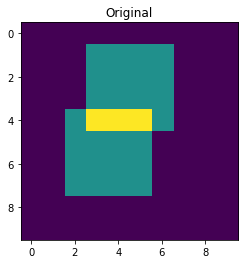

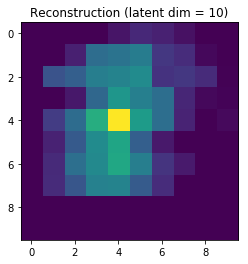

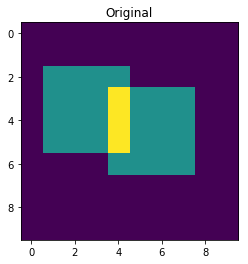

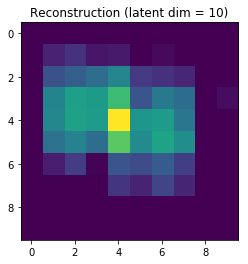

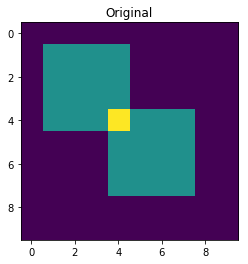

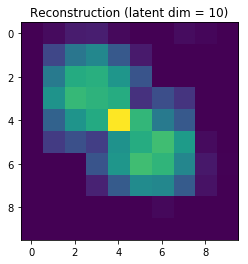

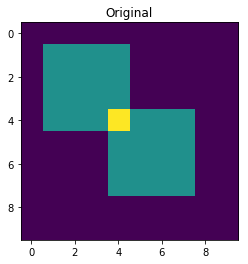

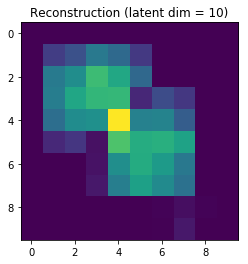

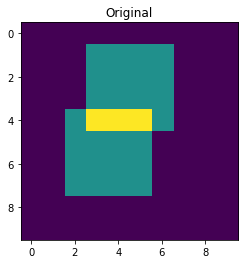

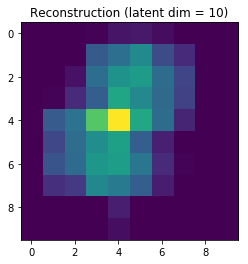

In [52]:
n = 1000
losses = run_train_sim(n)

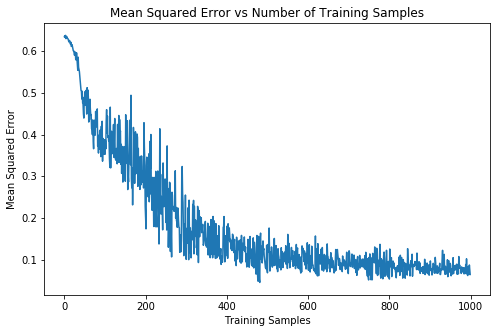

In [53]:
plt.figure(figsize=(8, 5))
plt.title('Mean Squared Error vs Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.xlabel('Training Samples')
plt.plot([i for i in range(n)], losses)
plt.show()

# Collman 15 Data

In [54]:
data = pickle.load(open('../../../../../get_data/collman15_downsample.pkl', 'rb'))
print(data.keys())

dict_keys(['VGluT1_647', 'annotation', 'Synapsin647', 'GAD647', 'GS594', 'MBP488', 'NR1594', 'gephyrin594', 'PSD95_488', 'GABA488'])


In [55]:
training_volumes = np.stack([data['Synapsin647'], data['PSD95_488'], data['NR1594']])
training_volumes = np.moveaxis(training_volumes, 0, -1)
print(training_volumes.shape)

(27, 174, 243, 3)


In [56]:
def make_2d_examples(volume, window_shape):
    examples = []
    for z_slice in volume:
        for y_start in range(0,
                             z_slice.shape[0], 
                             window_shape[0]):
            for x_start in range(0,
                                 z_slice.shape[1],
                                 window_shape[1]):
                proposed_example = z_slice[y_start:y_start+window_shape[0], x_start:x_start+window_shape[1], :]
                if proposed_example.shape[0] == window_shape[0] and proposed_example.shape[1] == window_shape[1]:
                    examples.append(proposed_example)
                    
    for z_slice in volume:
        for y_start in range(int(window_shape[0]/2.),
                             z_slice.shape[0], 
                             window_shape[0]):
            for x_start in range(int(window_shape[1]/2.),
                                 z_slice.shape[1],
                                 window_shape[1]):
                proposed_example = z_slice[y_start:y_start+window_shape[0], x_start:x_start+window_shape[1], :]
                if proposed_example.shape[0] == window_shape[0] and proposed_example.shape[1] == window_shape[1]:
                    examples.append(proposed_example)                   
                
    return examples

In [57]:
example_set = make_2d_examples(training_volumes, (10, 10))

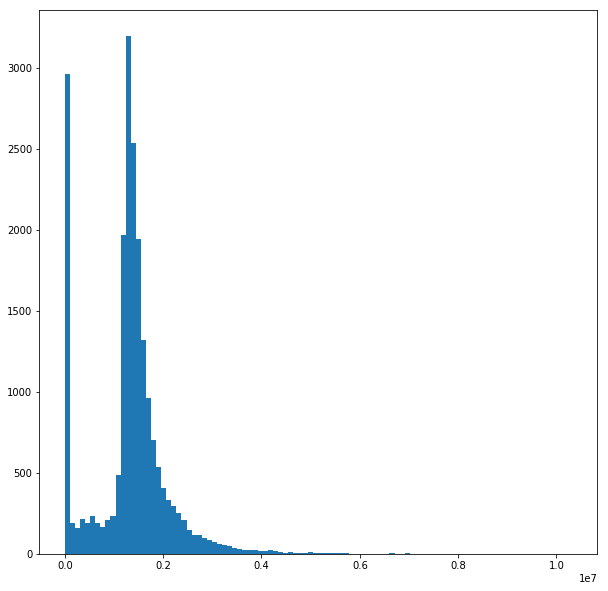

In [58]:
areas = [np.sum(np.abs(elem))\
         for elem in example_set]
plt.figure(figsize=(10, 10))
plt.hist(areas, bins=100)
plt.show()

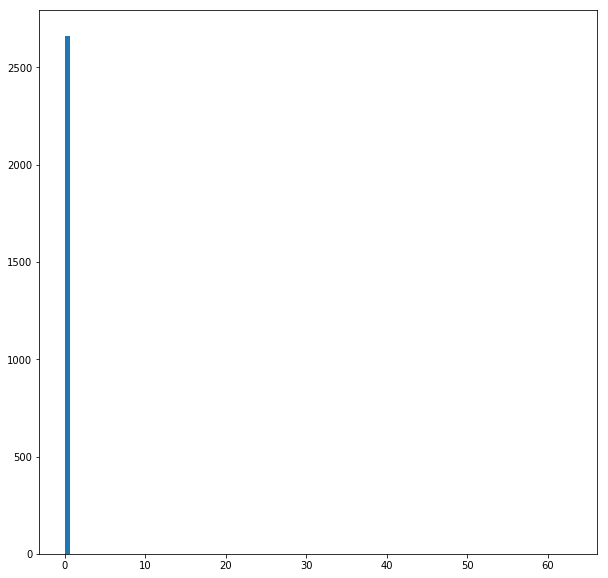

In [59]:
small_areas = [elem\
               for elem in areas\
               if np.sum(np.abs(elem)) < 100]
plt.figure(figsize=(10, 10))
plt.hist(small_areas, bins=100)
plt.show()

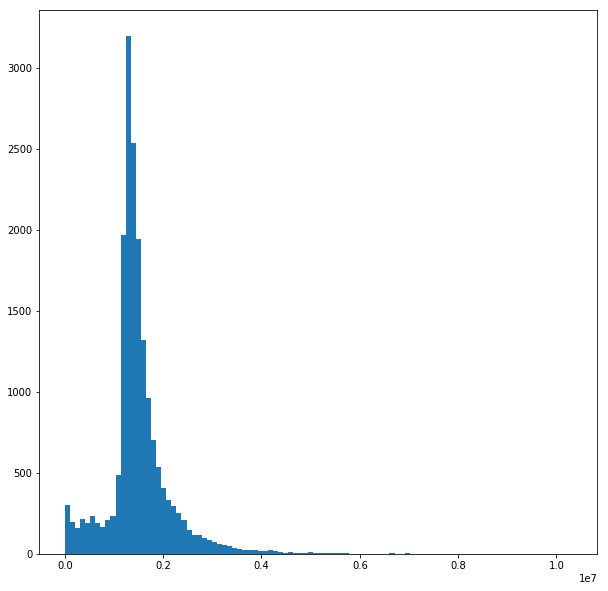

In [60]:
reduced_areas = [elem\
                 for elem in areas\
                 if np.sum(elem > 10)]

plt.figure(figsize=(10, 10))
plt.hist(reduced_areas, bins=100)
plt.show()

In [89]:
def augment_examples(examples):
    augmented_list = []
    for example in examples:
        for theta in list(range(30, 331, 30)):
            augmented_list.append(rotate(example.astype(float), theta))
            
    return examples + augmented_list
        

In [86]:
def whiten_example_set(examples):
    whitened_list = []
    examples = np.array(examples)
    chans = examples.shape[-1]
    for chan in range(chans):
        cur_examples = examples[:, :, :, chan]
        mu = np.mean(cur_examples)
        sigma = np.std(cur_examples)
        cur_whitened_examples = [(elem - mu)/sigma for elem in cur_examples]
        whitened_list.append(np.stack(cur_whitened_examples))
        
    whitened_stack = np.stack(whitened_list)
    whitened_stack = np.moveaxis(whitened_stack, 0, 3)
    return whitened_stack

In [97]:
collman_feature_encoder = FeatureEncoder((10, 10, 3),
                                         32,
                                         16,
                                         (5, 5))
batch_size = 64
epochs = 1
reduced_example_set = [elem\
                       for elem in example_set\
                       if np.sum(elem) > 0]

augmented_examples = augment_examples(reduced_example_set)
augmented_examples = augmented_examples + [np.zeros((10, 10, 3)) for _ in range(int(len(reduced_example_set)/8))]
whitened_examples = whiten_example_set(augmented_examples)
np.random.shuffle(whitened_examples)
losses = []
for epoch in range(epochs):
    for batch_start_idx in tqdm(range(0, len(whitened_examples), batch_size)):
        batch = np.array(whitened_examples[batch_start_idx:batch_start_idx+batch_size])
        batch_loss = collman_feature_encoder.train(batch)
        losses.append(batch_loss)

100%|██████████| 3466/3466 [00:25<00:00, 133.38it/s]


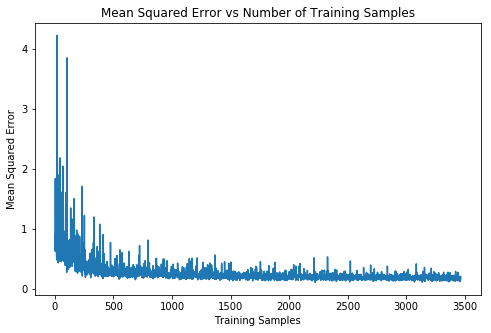

In [98]:
plt.figure(figsize=(8, 5))
plt.title('Mean Squared Error vs Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.xlabel('Training Samples')
plt.plot([i for i in range(len(losses))], losses)
plt.show()

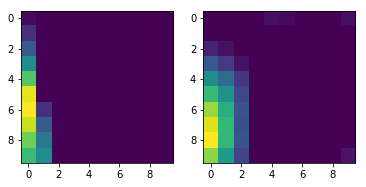

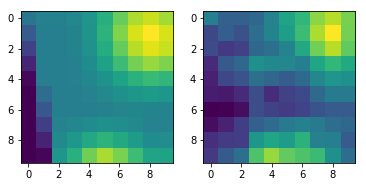

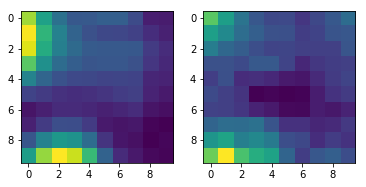

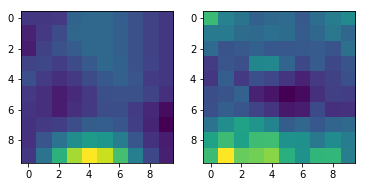

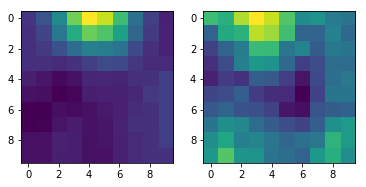

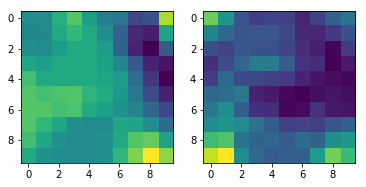

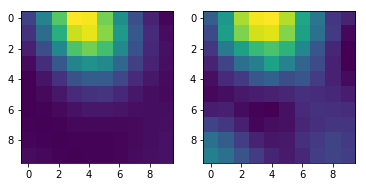

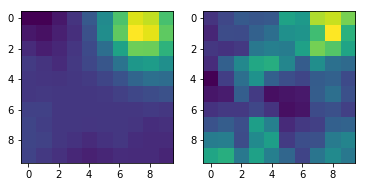

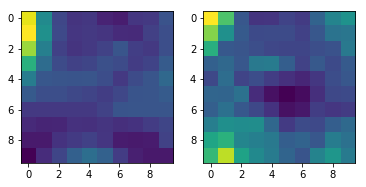

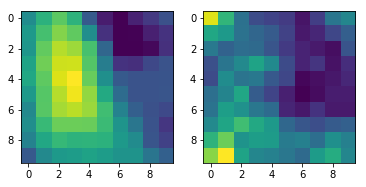

In [125]:
for i in range(100, 110):
    test_example = augmented_examples[i]
    reconstruction = collman_feature_encoder.reconstruct(np.array([test_example]))[0]

    plt.figure()
    plt.subplot(121)
    plt.imshow(np.sum(test_example, axis=2))

    plt.subplot(122)
    plt.imshow(np.sum(reconstruction, axis=2))
    plt.show()

In [126]:
label_annot = label(data['annotation'] > 0)

In [127]:
def get_train_idx_list(ratio):
    synapses = np.unique(label_annot)
    slice_max = int(ratio * len(synapses))
    random.shuffle(synapses)
    train_set = synapses[:slice_max]
    return train_set

In [132]:
def propose_negative_coordinates(lr, rr):
    centroid = [int(np.random.random() * (elem-1))\
                for elem in training_volumes.shape[:-1]]
    
    z = centroid[0]
    
    miny = centroid[1]-lr
    maxy = centroid[1]+rr
    
    minx = centroid[2]-lr
    maxx = centroid[2]+rr
   
    return z, miny, maxy, minx, maxx
    
    
def make_negative_feature_vector(lr, rr):
    z, miny, maxy, minx, maxx = propose_negative_coordinates(lr, rr)
    while np.max(label_annot[z, miny:maxy, minx:maxx]) > 0:
        z, miny, maxy, minx, maxx = propose_negative_coordinates(lr, rr)
        
    cutout = training_volumes[z, miny:maxy, minx:maxx, :]
    try:
        feature_vector = collman_feature_encoder.encode(np.array([cutout]))
        return feature_vector
    except:
        return None

In [133]:
def make_positive_feature_vector(train_idx, lr, rr):
    centroid = [int(np.mean(elem))\
                for elem in np.where(label_annot == train_idx)]
    
    z = centroid[0]
    
    miny = centroid[1]-lr
    maxy = centroid[1]+rr
    
    minx = centroid[2]-lr
    maxx = centroid[2]+rr
    
    cutout = training_volumes[z, miny:maxy, minx:maxx, :]
    try:
        feature_vector = collman_feature_encoder.encode(np.array([cutout]))
        return feature_vector
    
    #THIS IS BAD AND I FEEL BAD -DIJKSTRA FORGIVE ME
    except:
        return None

In [134]:
def run_lda_sim(train_ratio, lr, rr):
    #get random data split
    train_idx_list = get_train_idx_list(train_ratio)
    train_positives = [make_positive_feature_vector(train_idx, lr, rr)\
                       for train_idx in train_idx_list]
    
    parsed_train_positives = [elem\
                              for elem in train_positives\
                              if not elem is None]
    
    
    train_negatives = [make_negative_feature_vector(lr, rr)\
                       for _ in train_positives]
    
    parsed_train_negatives = [elem\
                              for elem in train_negatives\
                              if not elem is None]
    
    train_feature_vectors = parsed_train_positives + parsed_train_negatives
    train_labels = [1 for _ in parsed_train_positives] + [0 for _ in parsed_train_negatives]
    
    #train model
    lda_model = LDA()
    lda_model.fit(train_feature_vectors, train_labels)
    
    #test model
    test_positive_idx_list = [elem\
                              for elem in np.unique(label_annot)\
                              if not elem is None]
    
    test_positives = [make_positive_feature_vector(elem, lr, rr)\
                      for elem in test_positive_idx_list]
    
    parsed_test_positives = [elem\
                             for elem in test_positives\
                             if not elem is None]
    
    test_negatives = [make_negative_feature_vector(lr, rr)\
                      for _ in train_positives]
    
    
    parsed_test_negatives = [elem\
                             for elem in test_negatives\
                             if elem.shape[0] == 10 and elem.shape[1] == 10]   
    
    positive_predictions = lda_model.predict(parsed_test_positives)
    negative_predictions = lda_model.predict(parsed_test_negatives)
    
    #compute precision and recall
    rec = np.sum(positive_predictions)/len(test_positives)
    prec = np.sum(positive_predictions)/(np.sum(positive_predictions) + np.sum(negative_predictions))
    
    return prec, rec, len(train_feature_vectors)

In [135]:
run_lda_sim(.66, 5, 5)

ValueError: zero-size array to reduction operation maximum which has no identity